In [30]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
import numpy as np

np.set_printoptions(precision=2, linewidth=100)
torch.set_printoptions(precision=2, linewidth=100, sci_mode=False)

In [31]:
import minai.datasets as mds

x_train, y_train, x_val, y_val, x_test, y_test = mds.load_mnist()

In [32]:
from fastcore.test import test_close

In [33]:
n, m = x_train.shape
c = y_train.max() + 1
n, m, c

(50000, 784, tensor(10))

In [34]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [35]:
nh = 50

model = Model(m, nh, 10)
preds = model(x_train)
preds.shape

torch.Size([50000, 10])

In [36]:
def softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True)))

In [37]:
softmax(preds[0])

tensor([0.09, 0.11, 0.10, 0.12, 0.08, 0.09, 0.10, 0.09, 0.10, 0.12], grad_fn=<DivBackward0>)

In [38]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [39]:
log_softmax(preds[0])

tensor([-2.43, -2.22, -2.26, -2.14, -2.52, -2.46, -2.33, -2.38, -2.26, -2.11],
       grad_fn=<LogBackward0>)

In [40]:
def log_softmax(x): return x - (x.exp().sum(-1, keepdim=True)).log()

In [41]:
log_softmax(preds[0])

tensor([-2.43, -2.22, -2.26, -2.14, -2.52, -2.46, -2.33, -2.38, -2.26, -2.11],
       grad_fn=<SubBackward0>)

In [42]:
def logsumexp(x):
    a = x.max(-1)[0]
    return m + (x - a.unsqueeze(-1)).exp().sum(-1).log()

In [43]:
logsumexp(preds[0])

tensor(786.11, grad_fn=<AddBackward0>)

In [44]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [45]:
log_softmax(preds[0])

tensor([-2.43, -2.22, -2.26, -2.14, -2.52, -2.46, -2.33, -2.38, -2.26, -2.11],
       grad_fn=<SubBackward0>)

In [46]:
sm_preds = log_softmax(preds)

In [47]:
y_train[:3]

tensor([5, 0, 4])

In [48]:
sm_preds[0, 5], sm_preds[1, 0], sm_preds[2, 4]

(tensor(-2.46, grad_fn=<SelectBackward0>),
 tensor(-2.42, grad_fn=<SelectBackward0>),
 tensor(-2.43, grad_fn=<SelectBackward0>))

In [49]:
sm_preds[[0,1,2], [5,0,4]]

tensor([-2.46, -2.42, -2.43], grad_fn=<IndexBackward0>)

In [50]:
sm_preds[range(3), y_train[:3]]

tensor([-2.46, -2.42, -2.43], grad_fn=<IndexBackward0>)

In [51]:
def nll(inp, targ): return -inp[range(targ.shape[0]), targ].mean()

In [52]:
loss = nll(sm_preds, y_train)
loss

tensor(2.31, grad_fn=<NegBackward0>)

In [53]:
test_close(F.nll_loss(F.log_softmax(preds, -1), y_train), loss, 1e-3)
test_close(F.cross_entropy(preds, y_train), loss, 1e-3)

In [54]:
loss_func = F.cross_entropy

In [55]:
bs = 50
xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.10,  0.10,  0.06,  0.18, -0.20, -0.13, -0.01, -0.06,  0.06,  0.21],
        grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [56]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3,
        8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [57]:
loss_func(preds, yb)

tensor(2.29, grad_fn=<NllLossBackward0>)

In [59]:
preds.argmax(1)

tensor([9, 1, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 9, 3, 3, 3,
        3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 9])

In [62]:
def accuracy(preds, yb): return (preds.argmax(1) == yb).float().mean()

In [63]:
accuracy(preds, yb)

tensor(0.10)

In [64]:
lr = 0.5
epochs = 3

In [65]:
def report(loss, preds, yb): print(f"{loss:.2f}, {accuracy(preds, yb):.2f}")

In [67]:
xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.29, 0.10


In [71]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if type(l) is nn.Linear:
                    l.weight -= lr*l.weight.grad
                    l.weight.grad.zero_()
                    l.bias -= lr*l.bias.grad
                    l.bias.grad.zero_()

    report(loss, preds, yb)


0.04, 0.98
0.05, 0.98
0.02, 1.00


In [72]:
m1 = nn.Module()
m1.foo = nn.Linear(1, 2)
m1

Module(
  (foo): Linear(in_features=1, out_features=2, bias=True)
)

In [73]:
list(m1.named_children())

[('foo', Linear(in_features=1, out_features=2, bias=True))]

In [74]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.57],
         [ 0.66]], requires_grad=True),
 Parameter containing:
 tensor([ 0.32, -0.94], requires_grad=True)]

In [75]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [85]:
model = MLP(m, nh, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [86]:
for name, l in model.named_children():
    print(name, l)

l1 Linear(in_features=784, out_features=50, bias=True)
l2 Linear(in_features=50, out_features=10, bias=True)
relu ReLU()


In [87]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [88]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr*p.grad
                    p.grad.zero_()

        report(loss, preds, yb)


In [89]:
fit()

0.09, 0.98
0.07, 0.98
0.04, 1.00


In [92]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)

    def __repr__(self):
        return str(self._modules)
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [93]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [94]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [95]:
from functools import reduce

In [97]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [99]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer-{i}", l)

    def forward(self, x):
        func = lambda val, layer: layer(val)
        return reduce(func, self.layers, x)

In [100]:
model = Model(layers)
model

Model(
  (layer-0): Linear(in_features=784, out_features=50, bias=True)
  (layer-1): ReLU()
  (layer-2): Linear(in_features=50, out_features=10, bias=True)
)

In [104]:
model(xb).shape

torch.Size([50, 10])

In [105]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x


In [106]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [108]:
fit()

0.14, 0.94
0.09, 0.98
0.12, 0.94


In [112]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [113]:
fit()

0.14, 0.96
0.12, 0.96
0.03, 1.00


In [114]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [137]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params = tuple(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

    def step_and_zeo(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                p.grad.zero_()


In [138]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = Optimizer(model.parameters())

In [139]:
len(opt.params)

4

In [140]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.21, 0.94
0.16, 0.94
0.13, 0.96


In [141]:
from torch import optim

In [142]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [143]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [144]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.22, 0.92
0.14, 0.98
0.08, 0.98


In [145]:
class Dataset:
    def __init__(self, x, y): 
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]



In [147]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_val, y_val)

In [149]:
xb, yb = train_ds[0:5]
xb.shape, yb.shape

(torch.Size([5, 784]), torch.Size([5]))

In [153]:
model, opt = get_model()

In [154]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(i+bs, n)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.15, 0.96
0.12, 0.96
0.10, 0.98


In [156]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs

    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [159]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, 2*bs)

In [160]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

tensor(5)

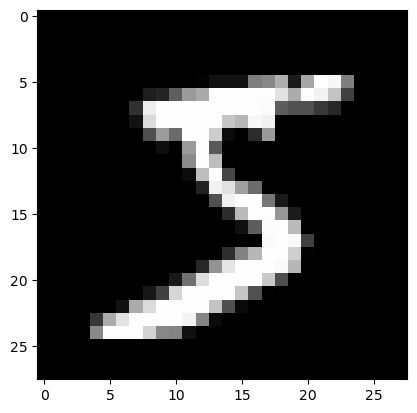

In [163]:
plt.imshow(xb[0].view(28, 28), cmap="gray")
yb[0]

In [164]:
model, opt = get_model()

In [165]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

0.15, 0.96
0.07, 0.96
0.03, 1.00


In [167]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.02, 1.00
0.02, 1.00
0.01, 1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [168]:
import random

In [222]:
class Sampler:
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle

    def __iter__(self):
        l = list(range(self.n))
        if self.shuffle: random.shuffle(l)
        return iter(l)

In [170]:
from itertools import islice

In [171]:
ss = Sampler(train_ds)

In [172]:
it = iter(ss)
for i in range(5): print(next(it))

0
1
2
3
4


In [214]:
list(islice(iter(range(4)), 5))

[0, 1, 2, 3]

In [218]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False):
        self.sampler = sampler
        self.bs = bs
        self.drop_last = drop_last

    def __iter__(self):
        it = iter(self.sampler)
        done = False
        while not done:
            buf = list(islice(it, self.bs))
            done = len(buf) < self.bs

            if done:
                if not buf:
                    break

                if self.drop_last:
                    break
                else:
                    buf.extend(islice(iter(self.sampler), self.bs - len(buf)))

            yield buf

In [219]:
batches = BatchSampler(Sampler(list(range(5))), 4, drop_last=False)
for batch in batches:
    print(batch)

[0, 1, 2, 3]
[4, 0, 1, 2]


In [220]:
batches = BatchSampler(Sampler(list(range(5))), 4, drop_last=True)
for batch in batches:
    print(batch)

[0, 1, 2, 3]


In [227]:
class DataLoader:
    def __init__(self, ds: Dataset, batchs):
        self.ds = ds
        self.batchs = batchs

    def __iter__(self):
        for batch in self.batchs:
            yield self.ds[batch]

In [228]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [229]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

In [231]:
xb, yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

tensor(3)

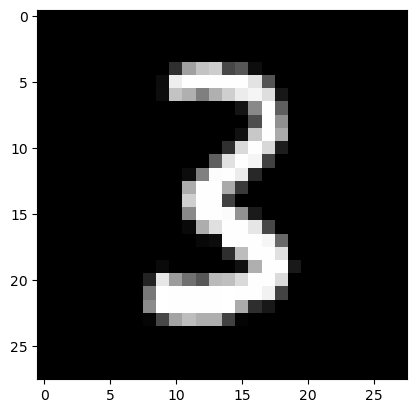

In [233]:
plt.imshow(xb[0].view(28, 28), cmap="gray")
yb[0]

In [234]:
model, opt = get_model()

In [235]:
fit()

0.17, 0.94
0.10, 0.96
0.08, 0.98


In [236]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [240]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

train_dl = DataLoader(train_ds, batch_sampler=train_samp)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp)

tensor(3)

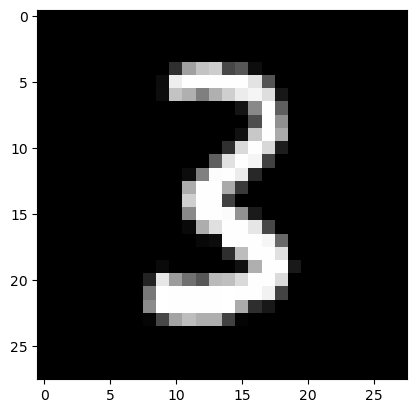

In [242]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28), cmap="gray")
yb[0]

In [246]:
model, opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, 0.96
0.19, 0.94
0.19, 0.94


(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

In [247]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [248]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

In [277]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss = tot_acc = count = 0
            for xb, yb in valid_dl:
                preds = model(xb)

                count += n
                tot_loss += loss_func(preds, yb).item()*n
                tot_acc += accuracy(preds, yb).item()*n
            print(epoch, tot_loss/count, tot_acc/count)

    return tot_loss/count, tot_acc/count

In [284]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=2*bs, shuffle=False, **kwargs))


In [285]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

In [286]:
%%time 
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1427732758410275 0.9579000037908554
1 0.12787977872416378 0.9659000074863434
2 0.12326999111101031 0.9660000079870223
3 0.12117999971844257 0.964500008225441
4 0.12636485609225928 0.9655000054836274
CPU times: user 40.9 s, sys: 720 ms, total: 41.6 s
Wall time: 5.2 s


(0.12636485609225928, 0.9655000054836274)